# Votes analysis

Import votes.csv

In [231]:
import pandas as pd

file_name = "votes.csv"
data = pd.read_csv(file_name)

Data summary

In [232]:
print(data.describe())

       Whats is your age?  demographic_time  contiguous_box_plots_time  \
count           19.000000         20.000000                  20.000000   
mean            26.000000      46856.050000               30930.750000   
std              9.643651      54493.409828               42748.548427   
min             21.000000       6618.000000                 907.000000   
25%             22.000000      16337.250000                6052.250000   
50%             22.000000      22576.000000               13518.500000   
75%             23.000000      38066.250000               41563.500000   
max             50.000000     197050.000000              150686.000000   

       contiguous_md_plots_time  contiguous_violin_plots_time  \
count                  20.00000                     20.000000   
mean                10215.30000                   8208.550000   
std                 11756.13388                  10117.299699   
min                   578.00000                    438.000000   
25%     

Numerical summary

In [233]:
# keep only numerical columns
numerical_data = data.select_dtypes(include=['number'])
numerical_data.describe()

,Whats is your age?,demographic_time,contiguous_box_plots_time,contiguous_md_plots_time,contiguous_violin_plots_time,contiguous_bean_plots_time,ridgeline_plots_time,contiguous_d_heatmap_plot_time,continuous_colormap_plus_time,overlapping_box_plots_time,...,arc_diagram_plus_vs_overlapping_box_plots_time,arc_diagram_plus_vs_overlapping_md_plots,arc_diagram_plus_vs_overlapping_md_plots_time,arc_diagram_plus_vs_overlapping_violin_plots,arc_diagram_plus_vs_overlapping_violin_plots_time,arc_diagram_plus_vs_overlapping_bean_plots,arc_diagram_plus_vs_overlapping_bean_plots_time,arc_diagram_plus_vs_radial_edge_bundling,arc_diagram_plus_vs_radial_edge_bundling_time,Unnamed: 347
count,19.000000,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000,20.0000,20.000000,20.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,26.000000,46856.050000,30930.750000,10215.30000,8208.550000,4926.950000,7715.350000,3938.7500,5621.450000,10830.900000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,9.643651,54493.409828,42748.548427,11756.13388,10117.299699,5476.804557,10063.146799,3757.5793,8905.795384,25689.014754,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,21.000000,6618.000000,907.000000,578.00000,438.000000,332.000000,560.000000,448.0000,390.000000,446.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,22.000000,16337.250000,6052.250000,2373.50000,1666.500000,1122.000000,1451.750000,987.5000,1150.750000,1294.250000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,22.000000,22576.000000,13518.500000,6623.00000,3222.500000,1883.000000,3614.000000,2893.5000,2069.500000,4089.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,23.000000,38066.250000,41563.500000,13051.25000,13053.500000,8742.500000,10626.500000,6179.5000,4757.250000,6793.250000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,50.000000,197050.000000,150686.000000,44056.00000,38815.000000,16600.000000,41320.000000,14154.0000,32778.000000,117442.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [234]:
columns_names = list(data.columns)
columns_names_vs = list(filter(lambda e : e.__contains__("_vs_") and not e.__contains__("time"), columns_names))
#print(columns_names_vs)

solutions_names = list(set([e.split("_vs_")[0] for e in columns_names_vs] + [e.split("_vs_")[1] for e in columns_names_vs]))
solutions_names.sort()
#print(solutions_names)

In [235]:
columns_names_vs_times = [e + "_time" for e in columns_names_vs]
total_time = data[columns_names_vs_times].sum(axis=0).sum()
print("Total vote time : ", total_time)

Total vote time :  3470078.0


In [236]:
import math
import pandas as pd

def create_dist_matrix(data: pd.DataFrame, columns_names_vs: list, solutions_names: list, time_normalization: bool = False):
    dist_matrix = pd.DataFrame(index=solutions_names, columns=solutions_names)
    dist_matrix = dist_matrix.fillna(0)

    for vs in columns_names_vs:
        # Create a DataFrame from the two columns
        columns = pd.DataFrame({
            'vs': data[vs],
            'time': data[vs + "_time"]
        })
        
        columns.dropna(axis=0, inplace=True)

        sol1, sol2 = vs.split("_vs_")
        for id, row in columns.iterrows():        
            if row['vs'] == 0:
                continue
            
            if time_normalization:
                weight = math.log(row['time']) / math.log(total_time)
            else:
                weight = 1

            if row['vs'] == sol1:
                dist_matrix.loc[sol1, sol2] += 1 * weight
            elif row['vs'] == sol2:
                dist_matrix.loc[sol2, sol1] += 1 * weight
            else:   # Equal
                dist_matrix.loc[sol1, sol2] += 1/2 * weight
                dist_matrix.loc[sol2, sol1] += 1/2 * weight
    
    return dist_matrix


## Bradley-Terry

In [237]:
# bradley-terry model
import numpy as np
import scipy.optimize as opt

def bradley_terry_model(matrix, n):
    nb_solution = matrix.shape[0]
    p = np.ones(nb_solution)
    for _ in range(n):
        #print(p)
        p = _bradley_terry_model(matrix, p)
    
    return p

def _bradley_terry_model(matrix, p):
    nb_solution = matrix.shape[0]
    next_p = np.zeros(nb_solution)
    for i in range(nb_solution):
        nom = 0
        denom = 0
        for j in range(nb_solution):
            if i == j:
                continue
            nom += matrix.iloc[i][j] * p[j] / (p[i] + p[j])
            denom += matrix.iloc[j][i] / (p[i] + p[j])

        p[i] = nom / denom
    
    # normalize p with geometric mean
    geometric_mean = 1
    for e in p:
        geometric_mean *= e
    geometric_mean = geometric_mean ** (1/nb_solution)
    
    p = p / geometric_mean
    
    return p

## Analysis

Dist matrix without normalization

In [238]:
dist_matrix = create_dist_matrix(data, columns_names_vs, solutions_names, time_normalization=False)
print(dist_matrix)

                           arc_diagram_plus  contiguous_bean_plots  \
arc_diagram_plus                        0.0                    2.5   
contiguous_bean_plots                   3.5                    0.0   
contiguous_box_plots                    3.5                   11.0   
contiguous_d_heatmap_plot               1.5                    4.5   
contiguous_md_plots                     2.5                    8.0   
contiguous_violin_plots                 1.0                    5.5   
continuous_colormap_plus                3.5                    7.0   
overlapping_bean_plots                  1.5                    4.0   
overlapping_box_plots                   1.5                    3.5   
overlapping_md_plots                    1.5                    4.0   
overlapping_violin_plots                0.0                    4.5   
radial_edge_bundling                    0.0                    4.0   
ridgeline_plots                         2.5                    7.5   

                   

In [239]:
p = bradley_terry_model(dist_matrix, 100)
#print(p)

# transform p into a dataframe and add the name of the solution
p = pd.DataFrame(p, index=solutions_names, columns=["score"])
p = p.sort_values(by="score", ascending=False)
print(p)

                              score
ridgeline_plots            2.764316
contiguous_box_plots       2.670902
continuous_colormap_plus   1.927005
arc_diagram_plus           1.921242
contiguous_md_plots        1.500765
overlapping_bean_plots     0.810588
overlapping_violin_plots   0.718839
contiguous_violin_plots    0.677546
overlapping_md_plots       0.668069
contiguous_bean_plots      0.666591
overlapping_box_plots      0.640679
contiguous_d_heatmap_plot  0.632989
radial_edge_bundling       0.341892


Dist matrix with normalization

In [240]:
dist_matrix = create_dist_matrix(data, columns_names_vs, solutions_names, time_normalization=True)
print(dist_matrix)

                           arc_diagram_plus  contiguous_bean_plots  \
arc_diagram_plus                   0.000000               1.466835   
contiguous_bean_plots              1.761774               0.000000   
contiguous_box_plots               2.174193               5.737540   
contiguous_d_heatmap_plot          0.963447               2.399507   
contiguous_md_plots                1.147161               4.358397   
contiguous_violin_plots            0.505674               3.058271   
continuous_colormap_plus           1.745254               3.753627   
overlapping_bean_plots             0.690299               2.086715   
overlapping_box_plots              0.876809               1.693289   
overlapping_md_plots               0.975597               2.117113   
overlapping_violin_plots           0.000000               2.427158   
radial_edge_bundling               0.000000               2.033723   
ridgeline_plots                    1.382803               4.124096   

                   

In [241]:
p = bradley_terry_model(dist_matrix, 100)
#print(p)

# transform p into a dataframe and add the name of the solution
p = pd.DataFrame(p, index=solutions_names, columns=["score"])
p = p.sort_values(by="score", ascending=False)
print(p)

                              score
ridgeline_plots            2.888843
contiguous_box_plots       2.776600
continuous_colormap_plus   1.966682
arc_diagram_plus           1.913950
contiguous_md_plots        1.524637
overlapping_bean_plots     0.794168
overlapping_violin_plots   0.739001
contiguous_violin_plots    0.672491
overlapping_md_plots       0.661933
contiguous_bean_plots      0.645096
contiguous_d_heatmap_plot  0.641469
overlapping_box_plots      0.634973
radial_edge_bundling       0.316460


## Graph display using concordance 

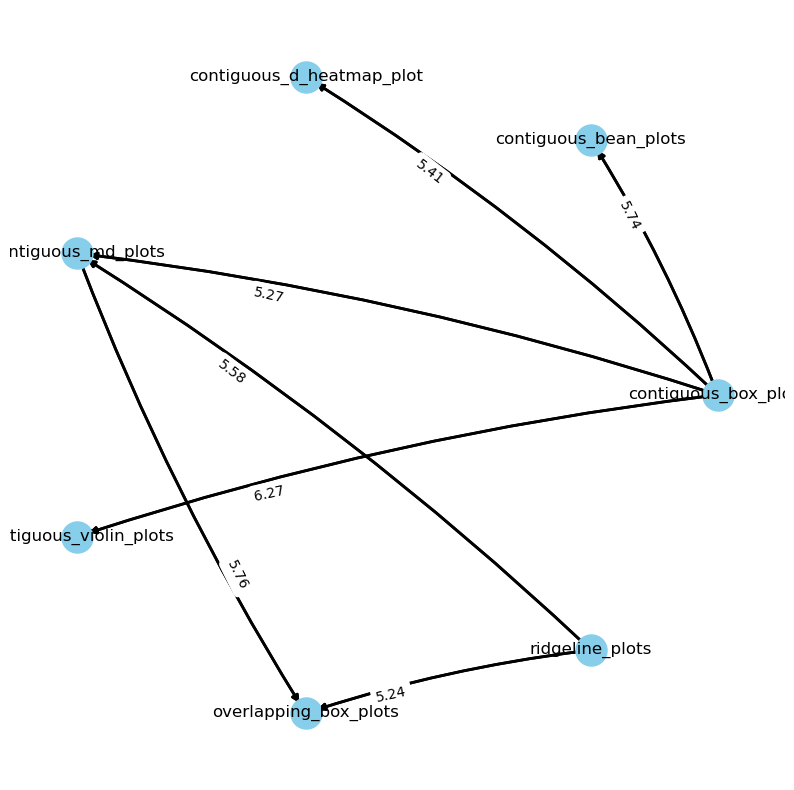

In [242]:
import networkx as nx
import matplotlib.pyplot as plt

# keep only two digit after the comma
dist_matrix = dist_matrix.round(2)

G = nx.MultiDiGraph()  # Use MultiDiGraph to allow multiple directed edges between nodes

threshold = 0.80 * dist_matrix.max().max()  # Set a threshold for the edges

for i in solutions_names:
    for j in solutions_names:
        if dist_matrix.loc[i, j] >= threshold:
            # Add multiple directed edges between nodes
            G.add_edge(i, j, weight=dist_matrix.loc[i, j])
        if dist_matrix.loc[j, i] >= threshold:
            G.add_edge(j, i, weight=dist_matrix.loc[j, i])  # Add edge in reverse direction

# Specify a layout algorithm
# pos = nx.spring_layout(G)
# circular layout
pos = nx.circular_layout(G)

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the size as needed

# Draw nodes
nx.draw_networkx_nodes(G, pos, ax=ax, node_size=500, node_color="skyblue")

curved_edges = [(u, v) for (u, v, d) in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, edgelist=curved_edges, ax=ax, width=2, arrows=True, connectionstyle='arc3, rad=0.05')

# Draw edge labels with offset
edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax, label_pos=0.3)

# Draw node labels
nx.draw_networkx_labels(G, pos, ax=ax, font_size=12, font_color="black")

# Show the plot
plt.axis('off')  # Turn off axis
plt.show()


In [243]:
import copy


def get_kernel(G: nx.MultiDiGraph):
    # Create a new directed graph
    G2 = copy.deepcopy(G)

    while True:
        # remove all nodes with out-degree equal to 0 and in-degree not equal to 0
        nodes_to_remove = [node for node in G2.nodes() if G2.out_degree(node) == 0 and G2.in_degree(node) != 0]
        
        if len(nodes_to_remove) == 0:
            break
        
        G2.remove_nodes_from(nodes_to_remove)

    return G2


def get_kernel(G: nx.MultiDiGraph):
    # Create a new directed graph
    G2 = copy.deepcopy(G)

    while True:
        # remove all nodes with out-degree equal to 0 and in-degree not equal to 0
        nodes_to_remove = [node for node in G2.nodes() if G2.out_degree(node) == 0 and G2.in_degree(node) != 0]
        
        if len(nodes_to_remove) == 0:
            break
        
        G2.remove_nodes_from(nodes_to_remove)

    return G2

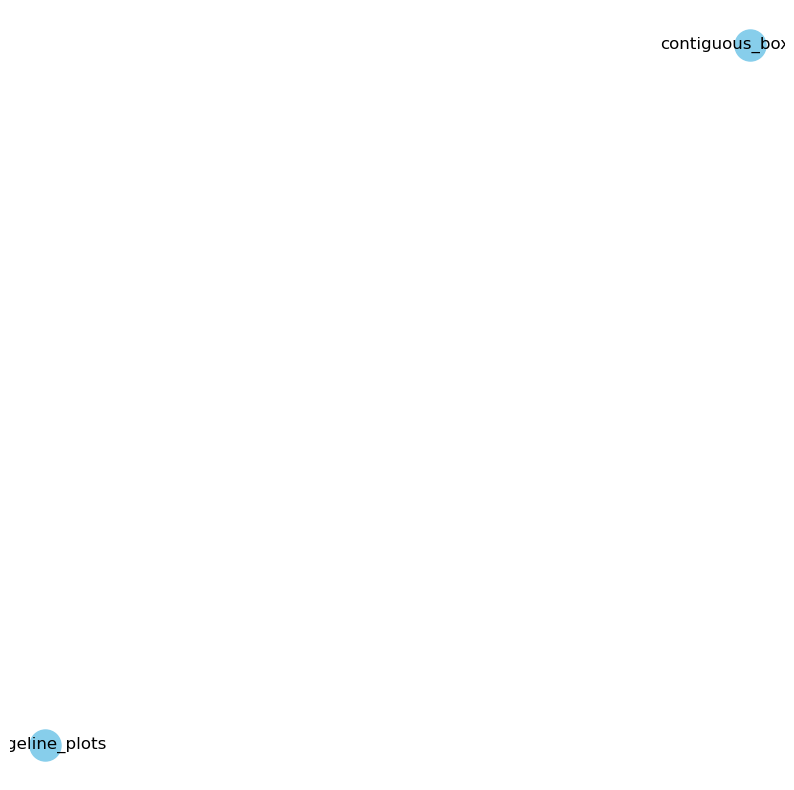

In [244]:
# select the kernel of the graph
kernel = get_kernel(G)

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the size as needed

# Draw nodes
nx.draw_networkx_nodes(kernel, pos, ax=ax, node_size=500, node_color="skyblue")

curved_edges = [(u, v) for (u, v, d) in kernel.edges(data=True)]
nx.draw_networkx_edges(kernel, pos, edgelist=curved_edges, ax=ax, width=2, arrows=True, connectionstyle='arc3, rad=0.05')

# Draw edge labels with offset
edge_labels = {(u, v): d['weight'] for u, v, d in kernel.edges(data=True)}
nx.draw_networkx_edge_labels(kernel, pos, edge_labels=edge_labels, ax=ax, label_pos=0.3)

# Draw node labels
nx.draw_networkx_labels(kernel, pos, ax=ax, font_size=12, font_color="black")

# Show the plot
plt.axis('off')  # Turn off axis
plt.show()

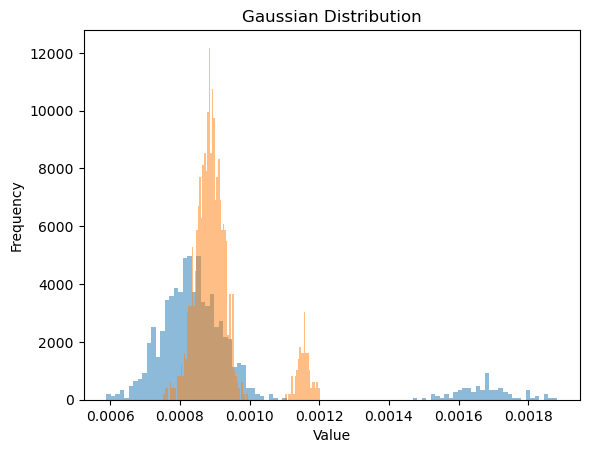

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Set the mean and standard deviation
mu = 10
sigma = 1

# Generate the vector of 100 values
vector = np.random.normal(mu, sigma, 1000)

# Generate upper outliers representing AFK
upper_outliers = np.random.normal(2 * mu, sigma, 100)
vector = np.concatenate((vector, upper_outliers))

# Creating log vector
vector_log = np.log(vector)

# Normalization
vector /= mu
vector_log /= np.mean(vector_log)

vector /= np.sum(vector)
vector_log /= np.sum(vector_log)

# Plot the distribution
plt.hist(vector, bins=100, density=True, alpha=0.5)
plt.hist(vector_log, bins=100, density=True, alpha=0.5)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Gaussian Distribution')
plt.show()
